<a href="https://colab.research.google.com/github/girotodenis/ReconhecimentoImagemVisaoComputacional/blob/master/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOME COMPLETO DOS INTEGRANTES DO GRUPO:
**Davi Miranda Gonçalves**, 
**Denis SIlva Giroto**,
**Naiara Moura Pires**

MATRÍCULAS DOS INTEGRANTES DO GRUPO:
**1931143030**,
**1931143029**,
**1931143033**

In [16]:
import numpy as np
import cv2
import imutils

import os
from google.colab.patches import cv2_imshow

!ls

Placa-Mercosul2.jpg  Placa-Mercosul.jpg  sample_data


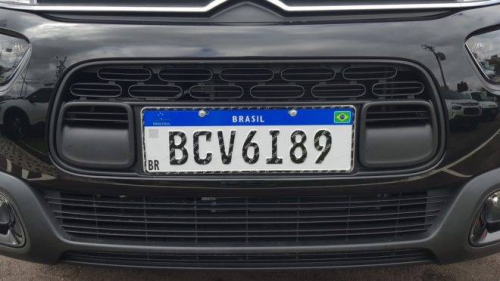

In [86]:
image = cv2.imread('Placa-Mercosul2.jpg')
image = imutils.resize(image, width=500)
cv2_imshow(image)

###Converter imagem para tons de cinza

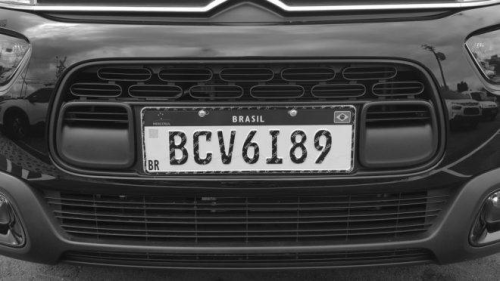

In [87]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

###Aplicar um filtro bilateral. 
Filtro de bilateral são eficaze na remoção de ruídos e mantem a bordas nitidas, a desvantagem que tem um custo alto, sendo mais lento em relação a outros filtros media, mediana e gausiana

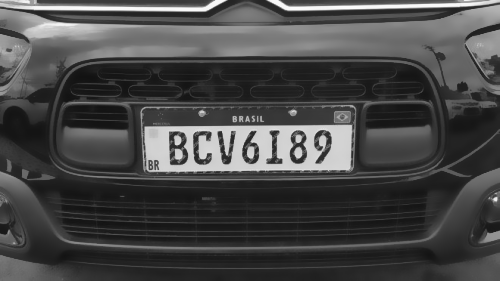

In [88]:
gray = cv2.bilateralFilter(gray, 11,17,17)
cv2_imshow(gray)

##Detecção das bordas por Canny
OpenCV tem uma função que ajuda a extrair contorno da imagem que funciona melhor em imagens binarias 

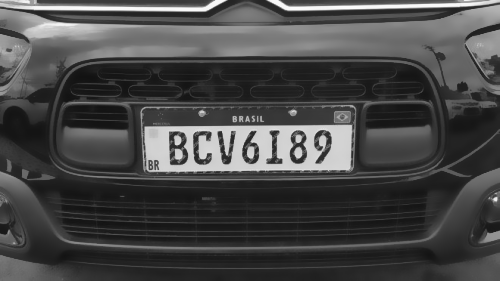

In [89]:
edged = cv2.Canny(gray, 170,200)
cv2_imshow(gray)

encontrar as bordas da imagem para encontrar a placa.


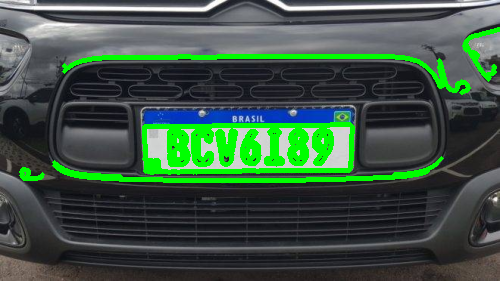

In [90]:
cnts, _ = cv2.findContours(edged.copy(),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

##odernar da maior area para menor, selecionar as 30 maiores
cnts = sorted(cnts,key=cv2.contourArea,reverse=True)[:30]
img1 = image.copy()
cv2.drawContours(img1, cnts, -1, (0,255,0),3)
cv2_imshow(img1)

Escolher entre os 30 contornos a melhor aproximação de uma placa

lados 4
Placa_1.png


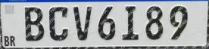

In [93]:
count = 0
idx = 1

x,y,w,h = (0,0,0,0)
for c in cnts:
  peri = cv2.arcLength(c,True)
  aprox = cv2.approxPolyDP(c, 0.02*peri,True)
  qtdl = len(aprox)
  print('lados',qtdl)
  if qtdl==4:
    x,y,w,h = cv2.boundingRect(c)
    break
  idx+=1

x,y,w,h = cv2.boundingRect(c)
placa = image[y:y+h, x:x+w]
nome_placa = 'Placa_'+str(idx)+'.png'
print(nome_placa)
cv2.imwrite(nome_placa, placa)
cv2_imshow(cv2.imread(nome_placa))